# Behavioural analyses of groups and people are carried out here. Thereby among other things competitors are recognized.

# 1. important!: open neo4j, gather required libraries

In [1]:
import os
import csv
from neo4j import GraphDatabase, basic_auth
import matplotlib.pyplot as plt
#currently neo4j is running on localhost
neo4jUrl = os.environ.get('NEO4J_URL',"bolt://localhost")
neo4jUser = os.environ.get('NEO4J_USER',"neo4j")
neo4jPass = os.environ.get('NEO4J_PASSWORD',"1")

driver = GraphDatabase.driver(neo4jUrl, auth=basic_auth(neo4jUser, neo4jPass))

graph = driver.session()

# 2. prepare function for printing pie chart

In [3]:
def printPieChart(title,data, chartLabels):


    plt.suptitle(title, fontsize=16)
    labels = chartLabels
    sizes = data
    patches, i,texts = plt.pie(sizes, shadow=True, startangle=90, autopct='%0.1f%%')
  #  plt.legend(patches, labels, loc="best")
    plt.legend(patches,labels, bbox_to_anchor=(1,0.5), loc="center left", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)
    plt.axis('equal')
    plt.show()    
    
    

# 3. parameters for Cypher-queries
The desired number of top values can be specified with the variable "amountOfReturnValues". 
e.g. value 5 for the top five results

In [11]:
allNodes_where_person_rsvpd_to_oracle_and_others = "match (g:Group)-[:ORGANIZES]->(e:Event)<-[:RSVPd]-(p:Person)-[:RSVPd]->(e2:Event)<-[:ORGANIZES]-(g2:Group)  where g.name <> g2.name and (g.name = 'Code4Fun' or g.name='Swiss Data Circle') and not(g2.name = 'Code4Fun' or g2.name='Swiss Data Circle')"
amountOfReturnValues = "5"

# List of Competitors of Code4Fun/SwissDataCircle 
List of Competitors: List of groups whose active members are also active members in Code4Fun/SwissDataCircle
Competitors are measured by the amount of common active members
Active members: members who have rsvp'd to events of a specific group
(Executes according to settings in step 3)

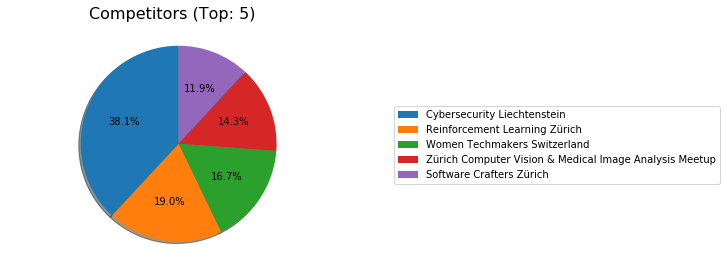

In [16]:
def get_competitors(tx):
    value = []
    key = []
    for record in tx.run(allNodes_where_person_rsvpd_to_oracle_and_others+" return distinct  g2.name, count(p) as amount_of_common_members order by amount_of_common_members desc limit "+amountOfReturnValues):
                          
        value.append(record["amount_of_common_members"])
        key.append(record["g2.name"])
    printPieChart("Competitors (Top: "+amountOfReturnValues+")",value, key)
        
with driver.session() as session:
    session.read_transaction(get_competitors)

# Oracle's group members who rsvps the most
Ranking of people who have rsvp'd to Oracle-events and have rsvpd elsewhere.
Ranking is based on amount of RSVPs of the specific person
(Executes according to settings in step 3)

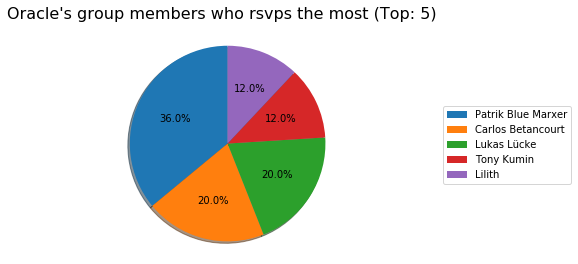

In [14]:

def get_oracle_members_who_rsvpd_most(tx):
    value = []
    key = []
    for record in tx.run(allNodes_where_person_rsvpd_to_oracle_and_others+" return distinct p.name as person_name, count(*) as rsvpd_event_amount order by rsvpd_event_amount desc limit "+amountOfReturnValues):
        value.append(record["rsvpd_event_amount"])
        key.append(record["person_name"])
       # print(str(record["rsvpd_event_amount"])  + "\t|" + str(record["person_name"]) )
    printPieChart("Oracle's group members who rsvps the most (Top: "+amountOfReturnValues+")",value, key)
with driver.session() as session:
    session.read_transaction(get_oracle_members_who_rsvpd_most)


# People who rsvp'd most to events
Ranking is based on amount of RSVPs of the specific person
(Executes according to settings in step 3)

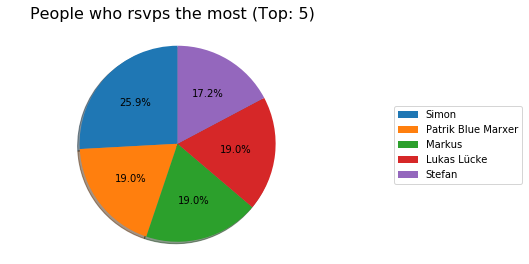

In [8]:
def get_people_who_rsvpd_most(tx):
    value = []
    key = []
    for record in tx.run("match (g:Group)-[:ORGANIZES]->(e:Event)<-[r:RSVPd]-(p:Person) return p.name as person_name, count(r) as rsvpd_event_amount order by rsvpd_event_amount desc limit "+amountOfReturnValues):
        value.append(record["rsvpd_event_amount"])
        key.append(record["person_name"])
    printPieChart("People who rsvps the most (Top: "+amountOfReturnValues+")",value, key)
with driver.session() as session:
    session.read_transaction(get_people_who_rsvpd_most)

# Groups that organize the most events
Ranking is based on amount of Events of the groups
(Executes according to settings in step 3)

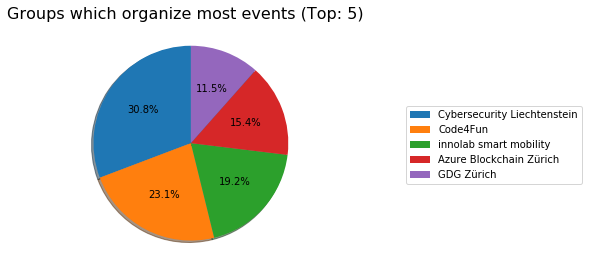

In [9]:
def get_group_ranking(tx):
    value = []
    key = []
    for record in tx.run("match (g:Group)-[:ORGANIZES]->(e:Event)  return g.name as Group, count(e) as amountOfEvents order by amountOfEvents desc limit "+amountOfReturnValues):
        value.append(record["amountOfEvents"])
        key.append(record["Group"])
    printPieChart("Groups which organize most events (Top: "+amountOfReturnValues+")" ,value, key)

with driver.session() as session:
    session.read_transaction(get_group_ranking)

# Instruction to add new questions

In order to answer additional questions and then insert them into the pie chart, the following steps should be taken: 
- A corresponding Cypher-query should be created, whereby only two columns (one key value and one value value) should be returned. 
- Both key and value are then passed as parameters into the "printPieChart", which creates a pie chart.
- The results should be sorted by value in descending order
- The desired number of return values (limit) should be specified so that the pie chart becomes easy-to-read.
Below is a syntactic example of how a cell could be programmed for such a new question.

def functionName(tx):
    value = []
    key = []
    for record in tx.run("match (a:A)-[:aToB]->(b:B)  return a.column as key, b.column as value order by value desc limit "+amountOfReturnValues):
        value.append(record["valueColumn"])
        key.append(record["keyColumn"])
    printPieChart("Sample title of Analysis (Top: "+amountOfReturnValues+")" ,value, key)

with driver.session() as session:
    session.read_transaction(functionName)